In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from functools import partial
import multiprocessing

In [79]:
seed = 4211

state = seed # memory of function LCG, keeps updating

a = 1559
c = 313
m = 13229

def LCG():
    '''LCG Random Number generator'''
    global state
    result = (a*state+c) % m
    state = result
    return hashfunc(state)

def npRNG():
    '''Numpy Random Number Generator'''
    if np.random.random() < 0.5:
        return -1
    else:
        return 1
    
def hashfunc(n):
    if n/m < 0.5:
        return -1
    else:
        return 1

def RandomWalk(steps, RNG):
    
    walks = []
    for i in range(steps):
        walks.append( [RNG(),RNG(),RNG()] ) # 3D random walk
    walks = np.array(walks)
    
    pos = walks.cumsum(axis=0) # cumulative sum of walks in every step
    
    return pos

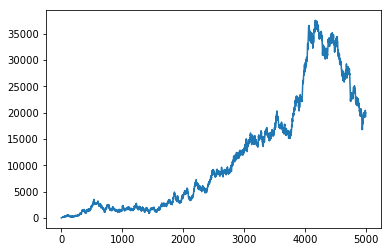

In [80]:
steps = 5000
pos = RandomWalk(steps, LCG)

MSDs = np.sum(pos**2, axis=1)

fig, ax = plt.subplots()
ax.plot(MSDs)
plt.show(fig)

In [12]:
def N_particle_walk(N, steps, RNG):
    '''Doing random walk for N particles with parallel computing'''
    pool = multiprocessing.Pool(processes=16)

    walk = partial(RandomWalk, RNG=RNG)
    particle_positions = pool.map(walk, np.ones(N,dtype=int)*steps)

    return np.array(particle_positions)
    
def pos_to_MSD_mean(N, walk_steps, sample_steps, particle_positions):
    '''1.sample the positions
       2.from positions to MSDs'''

    sample_size = walk_steps // sample_steps
    sample_indices = np.arange(sample_size) * sample_steps
    
    sample_positions = particle_positions[:,sample_indices,:]
    
    MSD_arr =  np.sum(sample_positions**2, axis=2)
    MSD_mean = np.sum(MSD_arr,axis=0) / N

    return sample_indices, MSD_mean
    

In [5]:
N = 20
walk_steps = 5000
sample_steps = 10
RNG = LCG
particle_positions = N_particle_walk(N, walk_steps, RNG)
sample_indices, MSD_mean = pos_to_MSD_mean(N, walk_steps, sample_steps, particle_positions)

standard error: [  4.96744522e-05]
slope: 3.5420642946681435
standard error: [  3.59816506e-05]
slope: 3.0699916846879973


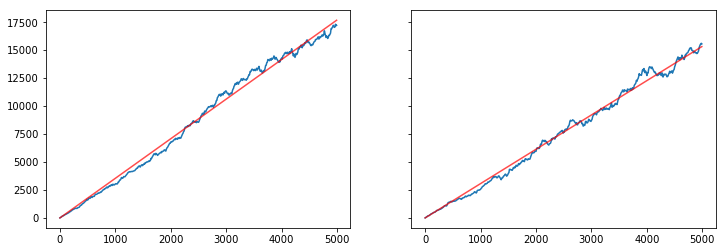

In [59]:
def linearity_test(RNG, ax):
    
    N = 500
    walk_steps = 5000
    sample_steps = 10
    particle_positions = N_particle_walk(N, walk_steps, RNG)
    xs, MSDs_mean = pos_to_MSD_mean(N, walk_steps, sample_steps, particle_positions)
    
    def f(x,slope):
        return slope*x

    popt, pcov = curve_fit(f, xs, MSDs_mean)
    linear = f(xs,*popt)

    print('standard error: {}'.format(*pcov))
    print('slope: {}'.format(*popt))

    ax.plot(xs, MSDs_mean)
    ax.plot(xs, linear, color='red', alpha=0.7)
    
fig, axes = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(12, 4))
linearity_test(LCG, axes[0])
linearity_test(npRNG, axes[1])
plt.show(fig)